In [1]:
import xrfclk
pl_clk = 500.18
xrfclk.set_ref_clks(lmk_freq = pl_clk) 

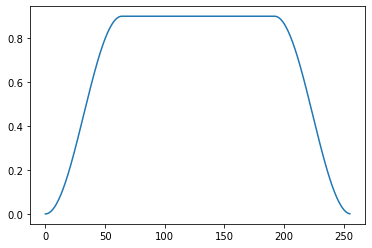

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def cos_edge_square(twidth,  dt, ramp_fraction=0.25):
    tedge=np.arange(0, 2*twidth*ramp_fraction, dt)
    t=np.arange(0, twidth, dt)
    width=len(t)
    if (ramp_fraction>0 and ramp_fraction<=0.5 and twidth>0):
        f=1.0/(2*ramp_fraction*twidth)
        edges=(np.cos(2*np.pi*f*tedge-np.pi)+1.0)/2.0
        #pyplot.plot(edges)
        #pyplot.show()
        nramp=int(len(edges)/2)
        nflat=width-len(edges)
        env=np.concatenate((edges[:nramp], np.ones(nflat), edges[nramp:]))
    else:
        print('ramp_fraction (ramp_length/twidth) should be 0<ramp_function<=0.5, %s and twidth>0 %s'%(str(ramp_fraction), str(twidth)))
        env=np.ones(width)
    return (t, env)

def gaussian(twidth, dt, sigmas=3):
    """
    Width is the exact width, not the width of the sigmas.
    sigmas is the number of sigma in the width in each side
    """
    #print 'gaussian', twidth, dt, sigmas
    t=np.arange(0, twidth, dt)
    #print len(t), len(np.arange(0, 4e-6, 1e-9))
    width=len(t)
    sigma = width / (2.0 * sigmas)  # (width - 1 )?
    val=np.exp(-(np.arange(0, width) - width / 2.) ** 2. / (2 * sigma ** 2)).astype('complex64')
    #print twidth, dt, width, len(t), len(val)
    #print t, val
    return (t, val)

def test():
    t, env = cos_edge_square(256, 1)
    plt.plot(t, env * 0.9)
    plt.show()

test()


In [ ]:
# utils for simulation

from riscq.assembler import *


from pynq import MMIO
# pulse_mem_offset = 0x80000000
# # PULSE_MEM = MMIO(pulse_mem_offset, 2 ** 24)
# PULSE_MEM = MMIO(pulse_mem_offset, 2 ** 28)
# inst_offset = 0x81000000
# INST_MEM = MMIO(inst_offset, 2 ** 24)
# rst_offset = 0x90000000
# RST_MEM = MMIO(rst_offset, 2 ** 8)
# readout_buffer_offset = 0x8f000000
# RO_BUF = MMIO(readout_buffer_offset, 2 ** 24)
# dmem_offset = 0x88000000
# DMEM = MMIO(dmem_offset, 2**24)

base_mem_offset = 0x80000000
pulse_mem_offset = 0x10000000
inst_offset = 0x00000000
rst_offset = 0x1fffff00
readout_buffer_offset = 0x0f000000

AXI_MM = MMIO(base_mem_offset, 0x20000000)

def reset_enable():
  AXI_MM.write(rst_offset, 0xffff)

def reset_disable():
  AXI_MM.write(rst_offset, 0x0000)

def read_mem(addr):
    res = AXI_MM.read(base_mem_offset + addr, 4)
    return res

def uint_to_sint(n, x):
    if x >= (1 << (n - 1)):
        return x - (1 << n)
    else:
        return x

def read_rob(addr):
    res = AXI_MM.read(readout_buffer_offset + addr, 4)
    r = uint_to_sint(16, res & 0xffff)
    i = uint_to_sint(16, res & 0xffff0000)
    return r, i

def load_inst(addr, insts):
  bins = assemble(insts)
  cur_addr = addr
  for inst in bins:
    slices = [inst[i:i+32] for i in range(0, 128, 32)]
    for slice in reversed(slices):
      AXI_MM.write(inst_offset + cur_addr, int(slice, 2).to_bytes(4, 'little'))
#       PULSE_MEM.write(cur_addr + 0x1000000, int(slice, 2).to_bytes(4, 'little'))
      cur_addr += 4

# def load_pulse(id, addr, env):
#   cur_addr = id * (2 ** 20) + addr
#   for d in env:
#     d_int = int(d * (2 ** 15))
#     d_bytes = d_int.to_bytes(2, 'little', signed = True)
#     PULSE_MEM.write(cur_addr, d_bytes)
#     print(d_int, d_bytes)
#     cur_addr += 2
def load_pulse(id, addr, env):
  cur_addr = id * (2 ** 20) + addr
  if len(env) % 2 == 1:
        env.append(0)
  grouped_env = [env[i:i+2] for i in range(0, len(env), 2)]
  for [d1, d2] in grouped_env:
    d1_int = int(d1 * (2 ** 15))
    d2_int = int(d2 * (2 ** 15))
    d1_bytes = d1_int.to_bytes(2, 'little', signed = True)
    d2_bytes = d2_int.to_bytes(2, 'little', signed = True)
    AXI_MM.write(pulse_mem_offset + cur_addr, d1_bytes+d2_bytes)
#     print(d_int, d_bytes)
    cur_addr += 4

In [ ]:
from elftools.elf.elffile import ELFFile
from elftools.elf.constants import SH_FLAGS


def load_elf_word(filename, write_word, offset):
  with open(filename, 'rb') as f:
    elf = ELFFile(f)
    for section in elf.iter_sections():
      # print(f"Section name: {section.name}, type: {section['sh_type']}")
      if((section['sh_flags'] & SH_FLAGS.SHF_ALLOC)):
        # print(f"addr: {section['sh_addr']}")
        addr = section['sh_addr']
        data = section.data()
        for i in range(0, len(data), 4):
          word = data[i:i+4]
          write_word(addr + i + offset, word)

def print_addr_data(addr, data):
  print(f"{hex(addr)} {data.hex()}")

# load_elf_word("test.elf", print_addr_data, -0x70000000)

In [ ]:
load_pulse(2, 0, [0.5]*4096)
# load_pulse(0, 0, env*0.5)
load_inst(0, insts)
reset_disable()

dr, di = read_dmem(0), read_dmem(4)
dr, di = uint_to_sint(32, dr), uint_to_sint(32, di)
print(dr, di)
for i in range(0, 2 ** 10, 4):
    real, imag = read_rob(i)
    print(real, end = ' ')

In [40]:
from pynq import Overlay
overlay = Overlay("./riscq-loop20-rob.bit")

In [53]:

freq = int((1<<15) / 1024.0)
# freq = 0
# amp = (1<<15) - 1
amp = 1<<14

set_time = SETTIME(0)
carrier_dac2 = CARRIER(freq = freq, phase = 0, id = 2)
carrier_adc0 = CARRIER(freq = freq << 2, phase = 0, id = 4) # carrier id of adc_i is 2*qubit_num+i
send_pulse2 = PULSE(start = 70, addr = 0, duration = 1024, phase = 0, amp = amp, id = 2)
nop = ADDI(0, 0, 0)
wait0 = WAIT(120)
readout = READOUT(id = 0, time = 4)
wait1 = WAIT(500)
write_r = WRITER(rd = 3, id = 0)
write_i = WRITEI(rd = 4, id = 0)
save_r = SW(imm = 0, rs1 = 0, rs2 = 3)
save_i = SW(imm = 4, rs1 = 0, rs2 = 4)
stall = BEQ(0, 0, 0)

insts = [set_time, carrier_dac2, carrier_adc0, send_pulse2, wait0, nop, nop, readout, wait1, write_r, write_i, save_r, save_i, stall]

## prepare envelope
t, env = cos_edge_square(512, 1)

# start test
reset_enable()

# load_pulse(0, 0, [0]*4096)
load_pulse(2, 0, [0.5]*4096)
# load_pulse(0, 0, env*0.5)
load_inst(0, insts)
reset_disable()

dr, di = read_dmem(0), read_dmem(4)
dr, di = uint_to_sint(32, dr), uint_to_sint(32, di)
print(dr, di)
for i in range(0, 2 ** 10, 4):
    real, imag = read_rob(i)
    print(real, end = ' ')

-2644 69347
-514 -553 -591 -629 -612 -645 -677 -709 -671 -698 -724 -749 -691 -711 -731 -750 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [482]:
from pynq import Overlay
overlay = Overlay("./riscq-adc-debug.bit")

In [541]:

freq = int((1<<15) / 12.0)
# freq = 0
# amp = (1<<15) - 1
amp = 1<<14
# amp = 0

dac_id = 0
adc_id = 0

dac_phase = 0
# dac_phase = 1 << 15

set_time = SETTIME(0)
carrier_dac = CARRIER(freq = freq, phase = dac_phase, id = dac_id)
carrier_adc = CARRIER(freq = freq << 2, phase = 0, id = 4 + adc_id) # carrier id of adc_i is 2*qubit_num+i
send_pulse = PULSE(start = 70, addr = 0, duration = 2048, phase = 0, amp = amp, id = dac_id)
nop = ADDI(0, 0, 0)
wait0 = WAIT(190)
readout = READOUT(id = adc_id, time = 128)
wait1 = WAIT(2048)
write_r = WRITER(rd = 3, id = adc_id)
write_i = WRITEI(rd = 4, id = adc_id)
save_r = SW(imm = 0, rs1 = 0, rs2 = 3)
save_i = SW(imm = 4, rs1 = 0, rs2 = 4)
stall = BEQ(0, 0, 0)

insts = [set_time, carrier_dac, carrier_adc, send_pulse, wait0, nop, nop, readout, wait1, write_r, write_i, save_r, save_i, stall]

## prepare envelope
t, env = cos_edge_square(512, 1)

# start test
reset_enable()

# load_pulse(0, 0, [0]*4096)
load_pulse(0, 0, [0.9]*4096)
# load_pulse(0, 0, env*0.5)
load_inst(0, insts)
reset_disable()

dr, di = read_dmem(0), read_dmem(4)
dr, di = uint_to_sint(32, dr), uint_to_sint(32, di)
print(dr, di)
for i in range(0, 2 ** 10, 4):
    real, imag = read_rob(i)
    print(real, end = ' ')

52642 6893217
-4875 13262 -9055 -3905 13814 -8467 -4669 12694 -8893 -4113 13979 -8101 -4928 13270 -8981 -4006 13765 -8444 -4785 12718 -8885 -4225 13971 -8031 -5066 13292 -8901 -4011 13748 -8350 -4837 12748 -8759 -4341 13995 -7956 -4761 13292 -8842 -4198 13832 -8281 -4878 12722 -8700 -4425 14040 -7924 -5132 13301 -8774 -4255 13887 -8221 -4938 12770 -8653 -4525 14100 -7854 -5231 13272 -8728 -4295 13889 -8164 -5026 12758 -8565 -4538 14035 -7795 -5299 13340 -8631 -4375 13763 -8110 -5195 12774 -8546 -4567 14055 -7739 -5072 13339 -8552 -4459 13811 -8028 -5243 12799 -8427 -4760 14085 -7690 -5163 13340 -8510 -4554 13802 -7973 -5319 12754 -8404 -4789 14103 -7614 -5238 13293 -8443 -4638 14021 -7904 -5323 12804 -8339 -4880 14107 -7570 -5630 13350 -8384 -4686 13876 -7848 -5375 12796 -8219 -4986 14107 -7505 -5666 13332 -8281 -4749 13980 -7780 -5492 12802 -8139 -4998 14139 -7428 -5803 13356 -8224 -4836 13876 -7726 -5544 12793 -8132 -5081 14177 -7370 -5854 13335 -8145 -4959 14027 -7651 -5614 12793 -8

In [50]:
for i in range(159*4, 1024, 4):
    print(read_rob(i), end = ' ')

(0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (0, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) (498, 0) 

In [433]:
import time
reset_enable()
time.sleep(1)
reset_disable()


In [93]:
loadx2 = ADDI(imm = 123, rs1 = 0, rd = 2)
# loadx2 = ADD(rs1 = 0, rs2 = 0, rd = 2)
swx2 = SW(imm = 4, rs1 = 0, rs2 = 2)
stall = BEQ(0, 0, 0)
insts = [loadx2, swx2, stall]

reset_enable()
load_inst(0, insts)
reset_disable()

print(loadx2.bin_str(128))

print(read_dmem(0), read_dmem(4), read_dmem(8))
print(PULSE_MEM.read(0x08000000, 4))

00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111101100000000000100010011
0 123 0
0


In [3]:
# prepare data

## prepare instructions
set_time = SETTIME(10)

# the phase between each env point is freq / (2 ** 15) * pi
freq = int((1 << 15) / 4.0)
amp = (1 << 15) - 1
id = 0
set_carrier = CARRIER(freq = freq, phase = 0, id = id)
send_pulse = PULSE(start = 80, addr = 0, duration = 128, phase = 0, amp = amp, id = id)
send_pulse1 = PULSE(start = 128, addr = 0, duration = 128, phase = 0, amp = amp, id = id)
loop = BEQ(0, 0, 0)

insts = [set_time, set_carrier, send_pulse, send_pulse1, loop]
insts = [set_time, set_carrier, send_pulse, loop]
# insts = [set_time, set_carrier, loop]


## prepare envelope
t, env = cos_edge_square(128, 1)


In [12]:
# channel 1

## prepare instructions
set_time = SETTIME(10)

# the phase between each env point is freq / (2 ** 15) * pi
freq = int((1 << 15) / 8.0)
# freq = 0
amp = (1<<15)- 1
id = 0
set_carrier = CARRIER(freq = freq, phase = 0, id = id)
send_pulse = PULSE(start = 100, addr = 4095-1, duration = 32, phase = 0, amp = amp, id = id)
send_pulse1 = PULSE(start = 128, addr = 0, duration = 128, phase = 0, amp = amp, id = id)
loop = BEQ(0, 0, 0)

# insts = [set_time, set_carrier, send_pulse, send_pulse1, loop]
insts = [set_time, set_carrier, send_pulse, loop]
# insts = [set_time, set_carrier, loop]


## prepare envelope
t, env = cos_edge_square(512, 1)

# start test
reset_enable()

# load_pulse(0, 0, [0]*4096)
# load_pulse(0, 0, [-0.9]*64)
load_pulse(0, 0, env*0.5)
load_inst(0, insts)
reset_disable()

In [16]:
# channel 2

## prepare instructions
set_time = SETTIME(10)

# the phase between each env point is freq / (2 ** 15) * pi
# freq = int((1 << 15) / 64.0)
freq = 0
amp = (1<<14)-1
id = 1
set_carrier = CARRIER(freq = freq, phase = 0, id = id)
send_pulse = PULSE(start = 100, addr = 0, duration = 32, phase = 0, amp = amp, id = id)
# send_pulse1 = PULSE(start = 128, addr = 0, duration = 128, phase = 0, amp = amp, id = id)
loop = BEQ(0, 0, 0)

# insts = [set_time, set_carrier, send_pulse, send_pulse1, loop]
insts = [set_time, set_carrier, send_pulse, loop]
# insts = [set_time, set_carrier, loop]


## prepare envelope
t, env = cos_edge_square(512, 1)

# start test
reset_enable()

# load_pulse(1, 0, [0.9]*4096)
# load_pulse(1, 0, [-0.99]*256)
load_pulse(1, 0, env*0.9)
load_inst(0, insts)
reset_disable()

# 0 0x8000
# -0.5 0x6001
# -1.0 0x4003